In [1]:
##my stuff
from imagery_psychophysics.src.stirling_maps import sparse_point_maps as spm
from imagery_psychophysics.src.model_z import noise_grid

##other people's stuff
import math
import numpy as np
import pandas as pd
from PIL.Image import open
from PIL import Image
from scipy.misc import imresize
from os.path import join
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import LinearSegmentedColormap
from scipy.misc import comb as nCk
from time import time
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function, shared
from theano.tensor.extra_ops import repeat, to_one_hot
from matplotlib import pyplot as plt
from matplotlib.mlab import griddata
%matplotlib inline

/home/tnaselar/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.


# In which we introduce an upsampling step to the generative process.
So basically we now treat pixels in $Z$ as knot points, then upsample using nearest nbr interpolation to get the sampled object maps. We then base our estimates of count probability on these upsampled maps.

We'll call the number of "knot points" in the native $Z$-maps $D$, and the number of pixels in the upsampled $Z$-maps $D^{'}$

Note: As of 09/27/2017 this is not really working, I think because of a column-vs-row unraveling bug.

### Theano expressions

In [2]:
floatX = 'float32'

#### Generate samples of object maps from a posterior over object maps

In [3]:
##the variational posterior over object maps Z
##number of objects theano variable
_K = T.scalar('objects',dtype='int32')
_Q_Z = T.matrix('Q_Z')            ##(K,D)
_M = T.scalar('M',dtype='int32')
_upscale = T.scalar('upscale', dtype='int32')
_Z_shape_0 = T.scalar('Z_shape_0',dtype='int32')
_Z_shape_1 = T.scalar('Z_shape_1',dtype='int32')

##a theano random number generator
rng = MRG_RandomStreams(use_cuda = True)

##----sample M Z-maps from posterior Q_Z: (M x K x D)
##this gives a one-hot encoding of each pixel
_Z_samples = rng.multinomial(pvals = repeat(_Q_Z.T,_M,axis=0)).reshape((_Q_Z.shape[1],_M,_Q_Z.shape[0])).dimshuffle((1,2,0))

##this converts back to image format (M x D1 x D2), where D = D1*D2
_Z_images = _Z_samples.argmax(axis=1).reshape((_M,_Z_shape_0,_Z_shape_1), ndim=3)

##this upsamples the Z-maps using the "upscale" factor (M x D1' x D2'), where D' = D1'*D2'
_Z_upsamples = T.tile(_Z_images.dimshuffle(0,1,2,'x','x'), (_upscale,_upscale)).transpose(0,1,3,2,4).reshape((_M,_Z_shape_0*_upscale, _Z_shape_1*_upscale))

##this just records D', the number of pixels in the upsampled maps
_D_prime = T.prod(_Z_upsamples.shape[1:])

##this converts the Z-maps back to a one-hot encoding (M x K x D')
_Z_upsamples_one_hot = to_one_hot(_Z_upsamples.ravel()-1, _K).reshape((_M, _D_prime, _K)).transpose((0,2,1))

In [4]:
# D1,D2 = 4,4
# upscale = 7
# K = 2
# M = 3
# D_prime = (upscale*D1)**2
# foo = _Z_upsamples.eval({_Z_images:np.random.randint(0,K, size=(M,D1,D2)), _upscale:upscale, _M:M, _Z_shape_0:D1, _Z_shape_1:D2})
# baz = _Z_upsamples_one_hot.eval({_Z_upsamples:foo, _K:K, _M:M})

#### Object count probabilities (was previously calling this "object responsibility" because I vaguely remembered this type of jargon from studying EM).

In [5]:
##block of sampled object maps
_Z = T.tensor3('Z') ##(M x K x D)

##window index indicator (N X D)
_W = T.matrix('windows')


An expression for an (M,N) matrix of objects counts. Each row provides the object count in each window for one of the M object map samples in Z.

In [6]:
##(M x K x 1 x D)
##         N x D
##(M x K x N x D)  sum(D)
##(M x K x N)      clip(0,1)
##(M x K x N)      sum(K)
##(M x N)
_object_counts = T.sum(_Z.dimshuffle((0,1,'x',2))*_W,axis=-1).clip(0,1).sum(axis=1)

Now apply one-hot-encoding and sum across samples and divide to obtain object count probabilities 

In [7]:

##non-normalized object count probs (N x K)
_object_count_prob_nn = to_one_hot(_object_counts.astype('int32').flatten()-1,_K).reshape((_object_counts.shape[0],_object_counts.shape[1],_K)).sum(axis=0)

##object count probs (N x K)
_object_count_prob = _object_count_prob_nn / _object_count_prob_nn.sum(axis=1).reshape((_object_count_prob_nn.shape[0], 1))

#### Update variational posterior for one pixel

This will be the only update that returns a normalized variational posterior.
Uses the object_count_prob matrix above.  
Uses a place-holder for log-loglihood (lnP_star)

In [8]:
##K x N x K tensor of object count probs
##the first K is object id, the last K is object count
_oc_probs = T.tensor3('oc_probs') 

##N x K, this will just be the log of P_star. 
_lnP_star = T.matrix('lnP_star')

## K x 1, this is place holder for the dot product between pixel value and expected log of hyperparameters pi
_v = T.matrix('prior_penalties')

      ##K x N x K oc_probs
##(tensordot)
          ##N x K lnP_star 
      ##K x 1     lnQ_z
##(add V)
      ##K x 1
##(exp)
      ##K x 1     Q_z_nn
##(normalize)
      ##K x 1     Q_z, the variational posterior element for one pixel

##log of Q_z (minus unknown constant that normalizes things)    
_lnQ_z = T.tensordot(_oc_probs, _lnP_star, [[1,2], [0,1]]).dimshuffle([0,'x'])+_v

##non-normalized Q_z. we shift by max value to stabilize upcoming exp
_Q_z_nn = T.exp(_lnQ_z-T.max(_lnQ_z)) 

##variational posterior prob for one pixel
_Q_z = _Q_z_nn / _Q_z_nn.sum()

#### Update rule for the variational log posterior over theta (i.e., the noise parameters).
We calculate $ln[q(\theta)] - const$  
We use max of the above for calculating the ELBO.  
We use argmax of the above for updating the variational posteriors


In [9]:
_P_theta = T.tensor3('P_theta') ##(G x N x K)
_X = T.matrix('oc_prob_dummy') ##N x K ~ this is a place holder for the "object count prob" matrix
_lkhd_param_grid = T.matrix('lkhd_param_grid') ## G x 2 grid of candidate noise parameters. we must supply.

##(G x N x K)
##(    N x K)  (dot product, broadcast across G)
##(G x 1)  --> because we don't do vectors we reshape to make output 2Dimensional (G x 1)

##log of likelihood

_ln_P_theta = T.log(_P_theta)

##ln q(theta+, theta-) - const (G x 1)
_lnQ_theta = T.tensordot(_ln_P_theta, _X, axes=[[1,2], [0,1]],).reshape((_P_theta.shape[0], 1))

##---for max approximation

##find index of the best lkhd params (scalar integer)
_theta_star_idx = T.argmax(_lnQ_theta)
# _G = _lkhd_param_grid.shape[0]
# _theta_star_idx = T.argsort(_lnQ_theta)[T.iround(_G/2.)]

#N x K (windows x object counts)
_P_star = _P_theta[_theta_star_idx,:,:]

#1 x 2 best likelihood params
_theta_star = _lkhd_param_grid[_theta_star_idx,:]

##---for full bayesian treatment
_lnQ_theta_star = T.max(_lnQ_theta)
_Q_theta_nn = T.exp(_lnQ_theta - _lnQ_theta_star)
_Q_theta = _Q_theta_nn / _Q_theta_nn.sum()

#### Prior over object maps
The hyperparameter $\pi$ is prior over object sizes. It is Dirichlet distributed.  
We need $\mathbb{E}[ln[\pi]]$ to update Q_z. We'll also need it to calculate the ELBO.

In [10]:
_alpha_0 = T.scalar('alpha_0')
_q_Z = T.matrix('q_Z')  ##K x 1, this is result of summing over pixels in Q_Z matrix. very different from Q_z

_alpha = _q_Z + _alpha_0 ##broadcasts the scalar _alpha_0 across K

##(K x 1) this is needed to update Q_z
_Eln_pi = T.psi(_alpha) - T.psi(_alpha.sum())

##(K x 1) not needed for update of variational posteriors, but we'll want it for model interpretation
_E_pi = _alpha / _alpha.sum()

#### Expressions for the ELBO
This is an approximate ELBO because:  
1. We are using a $ln[q(\theta^*)]$ instead of $\mathbb{E}[ln[q(\theta)]]$, where $\theta^* = \underset{\theta}{\operatorname{argmax}}  q(\theta)$.
2. We approximate object count probabilities by sampling $M$ object maps from $Q_Z$ and computing a histogram

In [11]:
_lnQ_theta_star = T.scalar('lnQ_theta_star') ##scalar

_Q_Z_holder = T.matrix('Q_Z_holder') ##N x K 

##scalar: the entropy of the variational posterior
a_min = 10e-15
a_max = 1
_posterior_entropy = -T.tensordot(_Q_Z_holder.clip(a_min,a_max), T.log(_Q_Z_holder.clip(a_min,a_max)))

##scalar
_badness_of_fit = -_lnQ_theta_star

##scalar
_ELBO = -_badness_of_fit  + _posterior_entropy

#### Expressions for predictive distribution

In [12]:
_P_star_pred = T.matrix('lkhd_table_pred') ##K x K ~ responses x counts


##windows x 1         x counts  |
##          responses x counts    tensordot
##windows x responses

_pred_dist = T.tensordot(_object_count_prob, _P_star_pred, axes = [[1],[1]])



### Theano functions

#### Generate M samples of object maps from a variational posterior over all pixels, Q_Z

In [13]:
##returns M x K x D_prime (samples x object ids x pixels)
##this will be in the upsampled space
Z_sample_func = function([_Q_Z,_M,_K,_Z_shape_0,_Z_shape_1,_upscale],outputs=[_Z_upsamples, _Z_upsamples_one_hot])

#### Estimate object count probabilities from a stack of object map samples Z (given windows W)

In [14]:
##returns N x K (windows x object counts)
object_count_prob_func = function([_Z, _W, _K], outputs = _object_count_prob)

#### Update variational posterior for one pixel

In [15]:
##returns K x 1 (objects ids x 1)
Q_z_update_func = function([_oc_probs, _lnP_star, _v], outputs = _Q_z)

#### Update likelihood parameters (returns $\Theta^*$, $P^*$, and $q(\theta_+, \theta_-)$)

In [16]:
##returns theta_star ~ (1 x 2) best lkhd params
##returns P_star (N x K) (windows x object counts)
##return lnQ_theta G x 1
lkhd_update_func = function([_P_theta, _X, _lkhd_param_grid], outputs = [_theta_star, _P_star, _lnQ_theta, _Q_theta])

#### Update $\mathbb{E}[ln[\pi]]$ and $\mathbb{E}[\pi]$

In [17]:
##returns _Eln_pi (K x 1) (object ids x 1)
##returns _E_pi (K x 1) (object ids x 1)
prior_update_func = function([_q_Z, _alpha_0], outputs = [_Eln_pi, _E_pi])

#### Calculate the ELBO

In [18]:
## returns three scalar values. ELBO is last
ELBO_update_func = function([_Q_Z_holder, _lnQ_theta_star], outputs=[_badness_of_fit, _posterior_entropy, _ELBO])

#### Construct predictive distribution

In [19]:

pred_dist_func = function([_P_star_pred, _Z, _W, _K], outputs = _pred_dist)

### The likelihood function
A note on jargon/notation: p_on, p_off = theta_+, theta_- = likelihood parameters = noise parameters

In [20]:
##helper
def counts(r,c,K):
    return np.array([nCk(c,m)*nCk(K-c, r-m) for m in range(min(r,c)+1)])

##the strange likelihood I derived for this model
#
def lkhd(r,c,K,p_on,p_off):
    probs = np.array([(1-p_on)**(c-m) * (p_on)**m * (p_off)**(r-m) * (1-p_off)**(K-c-r+m) for m in range(min(r,c)+1)])
    #print probs
    return counts(r,c,K).dot(probs)

##create a stack of data likelihood tables for different values of the noise params 
def lkhd_grid(observed_responses, theta_dns, K):
    '''
    returns
    P_theta ~ G x N x K
    lkhd_param_grid ~ G x 2
    '''
    p_on, p_off = noise_grid(theta_dns,theta_dns)
    N = observed_responses.shape[0]  ##number of windows
    G = len(p_on) ##number of values of parameters to evaluate
    P_theta = np.zeros((G, N, K),dtype=floatX)
    lkhd_param_grid = np.zeros((G,2),dtype=floatX)
    for g,p in enumerate(zip(p_on,p_off)):
        lkhd_param_grid[g,0] = p[0]   ##let's make sure we get all indices in the same order
        lkhd_param_grid[g,1] = p[1]
        for n in range(N):
            for k in range(K):
                P_theta[g,n,k]  = lkhd(observed_responses[n].squeeze(),k+1,K, p[0],p[1])
    return P_theta, lkhd_param_grid

### Machinery for sampling-based likelihood maximization

In [21]:
##for generating stacks of one-hot-encoded object maps
def make_object_map_stack(K, num_rows, num_cols, image_dimensions,num_maps):
    size_of_field = int(np.mean(image_dimensions))
    D = np.prod(image_dimensions)
    object_map_base = spm(num_rows,num_cols,size_of_field,cluster_pref = 'random',number_of_clusters = K)
    object_maps = np.zeros((num_maps, K, D))
    for nm in range(num_maps):
        object_map_base.scatter()
        tmp = np.squeeze(object_map_base.nn_interpolation())
        tmp = imresize(tmp, image_dimensions, interp='nearest')
        ##convert to one_hot encoding
        tmp = np.eye(K)[tmp.ravel()-1].T  ##K x D
        object_maps[nm] = tmp
    return object_maps

In [22]:
##function for generating object counts
##get true object counts for each window
def get_object_counts(object_maps, windows):
    '''
    object_maps   =  M x K x D      newaxis
                     M x K x 1 x D
        windows   =          N x D  mult
                     M x K x N x D  sum(axis=-1)
                     M x K x N      clip(0,1).sum(axis=1)
    object_counts =  M x   x N      astype(int)
    
    '''
    return np.sum(object_maps[:, :,np.newaxis,:]*windows,axis=-1).clip(0,1).sum(axis=1).astype('int')


In [23]:
def get_noisy_object_counts(object_maps, windows, p_on, p_off):
    '''
    object_maps   =  M x K x D
        windows   =      N x D  
    
    returns
     noisy_object_counts  = M x N
    '''
    
    K = object_maps.shape[1]
    object_counts = get_object_counts(object_maps, windows) ##M x N
    M = object_counts.shape[0]
    N = object_counts.shape[1]
    observed_responses = np.zeros((M,N), dtype = 'int')
    for m in range(M):
        for n in range(N):
            resp_dist = np.zeros(K+1)
            oc = object_counts[m,n]
            for k in range(K+1):
                resp_dist[k] = lkhd(k,oc,K,p_on,p_off)
            observed_responses[m,n]=np.argmax(np.random.multinomial(1,resp_dist))
    return observed_responses

In [24]:
def my_to_one_hot(count_tensor, K):
    '''
    count_tensor  = M x N
    returns M x N x K
    '''
    M = count_tensor.shape[0]
    N = count_tensor.shape[1]
    one_hot_count_tensor = np.zeros((M, N, K))
    id_mat = np.eye(K)
    for m in range(M):
        one_hot_count_tensor[m,:, :] = id_mat[count_tensor[m]-1]
    return one_hot_count_tensor

In [25]:
##given some response, evaluate likelihoods of many object maps
def evaluate_log_likelihoods(observed_responses, object_map_stack, windows, p_on, p_off, lkhd_table=None):
    '''
    observed_responses  = 1 x N
    object_map_stack = M x K x D
    windows = N x D
    
    returns log_lkhds = M x 1
    '''
    N = observed_responses.shape[1]
    K = object_map_stack.shape[1]
    M = object_map_stack.shape[0]

    ##reshape observed_responses for convenience
    observed_responses = observed_responses.reshape((N,))
    ##create a likelihood table (N x K)
    if lkhd_table is None:
        lkhd_table = np.zeros((N,K), dtype=floatX)
        for n in range(N):
            for k in range(K):
                lkhd_table[n,k]  = np.log(lkhd(observed_responses[n],k+1,K, p_on,p_off))
            
    ##get object_counts ( M x N)
    object_counts = get_object_counts(object_map_stack, windows)
    
    ##one-hot encoding of object counts M x N x K
    one_hot_object_counts = my_to_one_hot(object_counts, K)
    
    
    ##evaluate log_likelihoods
    ## one_hot_object_counts = M x N x K
    ##            lkhd_table =     N x K tensordot
    ## log_lkhds = M x 1
    return np.tensordot(one_hot_object_counts, lkhd_table, axes=2)
    
    

In [26]:
##this will help visualize samples from Q_Z
def see_Z_sample(Z,image_shape,axis=0,show=True):
    '''
    Z ~ K x D
    convert to 1 x D, D[i] = j, j = argmax(Z[:,i])
    '''
    Z_image = np.argmax(Z,axis=axis).reshape(image_shape)
    if show:
        ax = plt.pcolor(Z_image,cmap='Dark2')
        plt.axes().set_aspect('equal', 'datalim')
    return Z_image


### Machinery for evaluating predictive distribution on test data

In [27]:
def create_lkhd_table(K, theta_plus, theta_minus):
    lkhd_table = np.zeros((K+1,K), dtype=floatX)
    for r in range(K+1):
        for c in range(K):
            lkhd_table[r,c] = lkhd(r,c+1, K, theta_plus, theta_minus)
    return lkhd_table
            

In [28]:
def eval_log_pred_dist(Q_Z, M, Z_shape_0,Z_shape_1,upscale, test_responses, test_windows, theta_plus, theta_minus, lkhd_table = None):
    '''
    Q_Z ~ K x D
    M  ~ number of samples
    test_responses ~ 1 x N
    test_windows ~ N x D
    theta_plus, theta_minus ignored if lkhd_table is provided
    lkhd_table ~ K+1 x K  = responses x counts(created if not provided)
    returns
        log_eval_PD
    '''
    N = test_responses.shape[1]
    resp_dx_list = (test_responses).ravel().astype('int').tolist()
    K = Q_Z.shape[0]
    if lkhd_table is None:
        lkhd_table = create_lkhd_table(K, theta_plus, theta_minus)
    Z_prime_samples, Z_prime_samples_1hot = Z_sample_func(Q_Z, M, K,Z_shape_0,Z_shape_1,upscale)
    PD = pred_dist_func(lkhd_table, Z_prime_samples_1hot.astype(floatX), test_windows, K)
    print N
    print PD.shape
    print np.max(resp_dx_list)
    eval_PD = PD[range(N), resp_dx_list]
    log_eval_PD = np.log(eval_PD)
    return log_eval_PD

In [29]:
def percent_correct(Q_Z, M, Z_shape_0,Z_shape_1,upscale,test_responses, test_windows, theta_plus, theta_minus, lkhd_table = None):
    N = test_responses.shape[1]
    K = Q_Z.shape[0]
    if lkhd_table is None:
        lkhd_table = create_lkhd_table(K, theta_plus, theta_minus)
    Z_prime_samples, Z_prime_samples_1hot = Z_sample_func(Q_Z, M,K,Z_shape_0,Z_shape_1,upscale)
    PD = pred_dist_func(lkhd_table, Z_prime_samples_1hot.astype(floatX), test_windows, K)
    predictions = np.argmax(PD, axis=1)
    fraction_correct = np.sum(test_responses==predictions) / (N*1.)
    return fraction_correct*100, predictions
    

### Real data

Grab the windows and images from a real experiment

In [30]:
##which repo?
drive = '/mnt/fast/'

##base directory
base = 'multi_poly_probes'

##pandas dataframe with all the experimental conditions and data
data_place = 'data'
data_file = 'multi_poly_probe_data_3_subjects.pkl'
subject = 'KL'
state = 'pcp'


##target images
image_place = 'target_images'
mask_place = 'masks'
target_image_name = 'candle_01'
target_image_file = target_image_name+'_letterbox.png'
mask_image_file = target_image_name+'_mask.tif'

##window files
window_place = 'probes'
window_file = target_image_name+'_letterbox_img__probe_dict.pkl'

Open the target image

In [31]:
##open
test_object_map = open(join(drive, base, image_place, target_image_file),mode='r').convert('L')


Open pandas dataframe 

In [32]:
experiment = pd.read_pickle(join(drive, base, data_place, data_file))
experiment.head()

,image,image_on,probe,resp_on,response,state,subj
0,candle_01,117.5410,11_12_21,127.8745,3.0,img,AS
1,candle_01,127.9244,15_7_16,139.0581,2.0,img,AS
2,candle_01,139.1078,32_24_33,151.4748,2.0,img,AS
3,candle_01,151.5415,37,156.2748,2.0,img,AS
4,candle_01,156.3414,18_10_19,163.0749,2.0,img,AS


In [33]:
print experiment.image.unique()
print experiment.subj.unique()

['candle_01' 'peaches_05' 'cheeseburger_03' 'grape_juice_02']
['AS' 'z1' 'KL']


Grab the windows, convert to right format, determine $N$ and initial $D$ 

In [34]:
##grad the windows. this take creates a dictionary with "index/mask" keys. 
windows = pd.read_pickle(join(drive, base, window_place, window_file))

In [35]:
N = len(windows['index'])
window_shape = windows['mask'][0].shape
aspect_ratio = window_shape[0]/(window_shape[1]*1.)
native_D = np.prod(window_shape)
W = np.zeros((N,native_D),dtype=floatX)

##reformat
for ii,w in enumerate(windows['mask']):
    W[ii,:] = w.ravel().clip(0,1)

Identify window with fewest pixels per object, use this to calculate downsampled image dimensions

In [36]:
##help
def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

In [37]:
##size of each window in pixels
window_size = W.sum(axis=1)

##responses of select subject / target image / cognitive state
resp = experiment[(experiment['image']==target_image_name) * (experiment['subj']==subject) * (experiment['state']==state)].response.values
resp = resp[np.newaxis,:]

##corresponding window indices
window_idx = experiment[(experiment['image']==target_image_name) * (experiment['subj']==subject) * (experiment['state']==state)].probe.values

##isolate window with fewest pixels per object
pix_per_object = window_size/resp
min_pix_per_object = np.min(pix_per_object)
min_dx = np.argmin(pix_per_object)
dns = 1./min_pix_per_object
fudge_factor = 1
dns_pixels = int(np.ceil(native_D*dns)*(fudge_factor))

/home/tnaselar/anaconda/lib/python2.7/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [38]:
def define_Z_shape(window_shape, K, resolution):

    ##calculate Z dimensions based upon K and the aspect ratio of the target image
    Z_shape = np.zeros((2), dtype='int32')

    ##the smallest dimension will be resolution*K
    min_dim = np.argmin(window_shape)
    max_dim = np.argmax(window_shape)

    Z_shape[min_dim] = int(round_up_to_even(resolution*K))
    Z_shape[max_dim] = int(round_up_to_even((Z_shape[min_dim]*window_shape[max_dim]*1.)/window_shape[min_dim]))

    ##the total number of pixels in Z
    print Z_shape
    D = np.prod(Z_shape)
    print D
    return Z_shape, D

In [39]:
resolution = 8
K = 2
Z_shape, D = define_Z_shape(window_shape, K, resolution)

[16 26]
416


In [40]:
##to what do we upsample Z (to what do we downsample the targe image and windows) ?
## so that window with fewest pixels per object has a pixel:object ratio of 1:1
##round up to nearest even number

min_image_dimensions = (int(round_up_to_even(np.sqrt(dns_pixels*aspect_ratio))), int(round_up_to_even(np.ceil(np.sqrt(dns_pixels/aspect_ratio)))))
upscale = np.round((np.max(min_image_dimensions)*1.)/np.max(Z_shape))

Z_prime_shape_0 = int(Z_shape[0]*upscale)
Z_prime_shape_1 = int(Z_shape[1]*upscale)

##the number of dimensions in the upsampled Z map. Don't think the variational algorithm actually needs this...
D_prime = np.prod((Z_prime_shape_0, Z_prime_shape_1))

print upscale
print Z_prime_shape_0, Z_prime_shape_1

1.0
16 26


smallest number of pixels per object: 681.000000
window pixels: 681
number of objects: 1
can downsample by 0.001468
for an image size of 416 pixels with dimensions 16 x 26


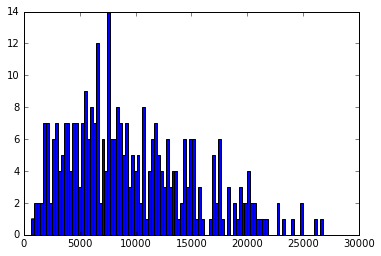

In [41]:
print 'smallest number of pixels per object: %f' %(min_pix_per_object)
print 'window pixels: %d' %(window_size[min_dx])
print 'number of objects: %d' %(resp[0,min_dx])
print 'can downsample by %f' %(dns)
print 'for an image size of %d pixels with dimensions %d x %d' %(D, Z_prime_shape_0, Z_prime_shape_1)
_=plt.hist(pix_per_object.squeeze(),100)

Open the image mask, downsample, digitize, convert to one-hot encoding, checking that no objects are lost.  
Note this plays no role in the analysis; we want this just for visualization

In [42]:
##open
test_object_map = open(join(drive, base, mask_place, mask_image_file),mode='r').convert('L')

##record K
values = np.array(np.unique(test_object_map))
imK = len(values)

In [43]:
##resize to window, checking for preserved K
test_object_map=imresize(test_object_map, (Z_prime_shape_0, Z_prime_shape_1), interp='nearest')
values = np.array(np.unique(test_object_map))
assert imK==len(values)

In [44]:
##digitize, checking 
test_object_map=np.digitize(np.array(test_object_map), bins=values, right=True ).astype(int)
values = np.array(np.unique(test_object_map))
assert imK==len(values)

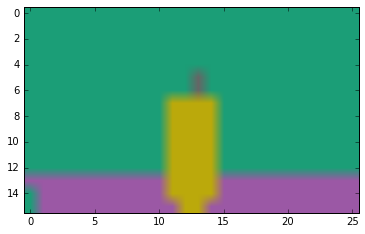

In [45]:
##one-hot encoding
test_object_map = np.eye(imK)[test_object_map.ravel()].T.reshape((1,imK,D_prime))

##view
test_object_map_image = see_Z_sample(test_object_map[0], (Z_prime_shape_0, Z_prime_shape_1), show=False)
plt.imshow(test_object_map_image, cmap='Dark2')
# plt.imshow(W[-5].reshape(image_di).astype('uint8')*255, interpolation='none', alpha = .2, cmap=plt.cm.gray, clim=[0,255])

#### Load windows in correct order, split in training/test responses

In [46]:

W = np.zeros((N,D_prime),dtype=floatX)

##reformat
for ii,w in enumerate(window_idx):
    str_dx = map(int, w.split('_'))
    dx = windows['index'].index(str_dx)
    dns_w = imresize(windows['mask'][dx], (Z_prime_shape_0,Z_prime_shape_1), interp='nearest')
    W[ii,:] =np.array(dns_w).ravel().clip(0,1)

print N

345


In [47]:
##randomize the samples for splitting
idx = np.random.permutation(range(N))

##the percent of data used for training
trn_prc = .8

##number of train and test samples
n_train = int(N*trn_prc)
n_test = N - n_train

##split the data into train and test
train_responses = resp[:,idx[:n_train]].astype(int)
train_windows = W[idx[:n_train],:]

test_responses = resp[:,idx[n_train:]].astype(int)
test_windows = W[idx[n_train:],:]

##this is NOT okay!
K = max([np.max(test_responses), np.max(train_responses)])
print K

2


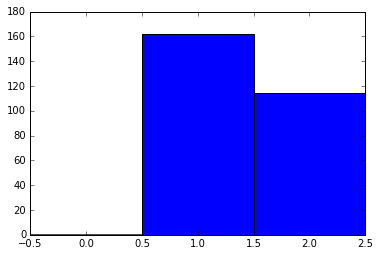

In [48]:
_=plt.hist(train_responses.T, bins = range(K+2), align = 'left', range = [0, K], )

### CAVI loop

#### Initialization functions

In [49]:
##need to first generate Z-maps, then upsample to Z-prime maps.
def init_Q_Z(observed_responses, windows, num_maps, theta_plus, theta_minus, dirichlet_param, K, Z_shape, Z_shape_prime):
    D = np.prod(Z_shape)
    map_stack = make_object_map_stack(K, 2*K, 2*K, Z_shape_prime,num_maps)
    starter_logs = evaluate_log_likelihoods(observed_responses, map_stack, windows, theta_plus, theta_minus)
    best_start_map = np.argmax(starter_logs)
    start_Z = map_stack[best_start_map] ## K x D_prime
    best_start_map_image=see_Z_sample(start_Z, Z_shape_prime, show=False)
    best_start_map_image_downsampled = np.round(imresize(best_start_map_image, Z_shape, interp='nearest')/255.).astype('int64')
    start_Z_downsampled = to_one_hot(best_start_map_image_downsampled.ravel(), K).reshape((D,K)).T.eval()
    Q_Z = np.zeros((K,D), dtype=floatX)
    for d in range(D): #np.random.permutation(D):
        Q_Z[:,d] = np.random.dirichlet(start_Z_downsampled[:,d]+dirichlet_param)
    return Q_Z, best_start_map_image, starter_logs

In [50]:
def init_Eln_pi(Q_Z, dirichlet_param):
    q_Z = Q_Z.sum(axis=1, keepdims=True) ##a fake q_Z, should be K x 1
    Eln_pi, _ = prior_update_func(q_Z, dirichlet_param)
    return Eln_pi

In [51]:
def init_P_star(observed_responses, theta_plus, theta_minus, K):
    N = observed_responses.shape[1]
    observed_responses = np.squeeze(observed_responses)
    P_star = np.zeros((N,K),dtype=floatX)
    for n in range(N):
        for k in range(K):
            P_star[n,k]  = lkhd(observed_responses[n],k+1,K, theta_plus,theta_minus)
    return P_star

#### Visualization functions

In [52]:
##visualize the variational posterior over pixels
def see_Q_Z(Q_Z, target_object_map = None, clim=[0,1]):
    ##view: construct an image grid
    fig = plt.figure(1, (30,10))
    K = Q_Z.shape[0]
    if target_object_map is not None:
        K += 1
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    if target_object_map is not None:
        im = grid[0].imshow(target_object_map,cmap='Dark2')
        grid[0].cax.colorbar(im)
        for kk in range(1,K):
            im = grid[kk].imshow(Q_Z[kk-1], cmap='hot', clim=clim)
            grid[kk].cax.colorbar(im)

    else: 
        for kk in range(0,K):
            im = grid[kk].imshow(Q_Z[kk], cmap='hot', clim=clim)
            grid[kk].cax.colorbar(im)

In [53]:
##visualize Q_theta (or lnQ_theta)
def see_Q_theta(Q_theta, lkhd_param_grid):
    ##name the data
    x = lkhd_param_grid[:,0]
    y = lkhd_param_grid[:,1]
    z = Q_theta.squeeze()
    
    # define grid.
    
    xi = np.linspace(-0.01, 1.01, 300)
    yi = np.linspace(-0.01, 1.01, 300)
    # grid the data.
    zi = griddata(x, y, z, xi, yi, interp='linear')
    # contour the gridded data, plotting dots at the nonuniform data points.
    CS = plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(xi, yi, zi, 15,
    vmax=abs(zi).max(), vmin=-abs(zi).max())
    plt.colorbar()  # draw colorbar
    # plot data points.
    plt.scatter(x, y, marker='o', s=5, zorder=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    

In [54]:
##object confusion matrix, sort of
##for each object, calculate the log-prob under the variational posterior for each class. return. display
def object_confusion(Q_Z, Z, show=False):
    '''
    log_prob_kj = (K x K) log-prob of class k in Q_Z given object j in object map Z
    '''
    K = Z.shape[0]
    log_prob = np.zeros((K,K))
    for k in range(K):
        for j in range(K):
            log_prob[k,j] = np.sum(np.log(Q_Z[k].clip(10e-15,1))*Z[j])
    
    if show:
        plt.pcolor(log_prob, cmap='gray')
        plt.axes().set_aspect('equal', 'datalim')
        plt.colorbar()
    return log_prob

def see_posterior_overlay(Q_Z, Z, image_dimensions):
    '''
    Q_Z ~ K x D
      Z ~ K x D
    '''
    ##view: construct an image grid
    fig = plt.figure(1, (40,20))
    K = Q_Z.shape[0]
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    
    colors = [(0, 0, 0), (1., 1., 0)]
    cm_1 = LinearSegmentedColormap.from_list(
        'object_map', colors, N=2)

    colors = [(0, 0, 0), (0., 0., 1.)]
    cm_2 = LinearSegmentedColormap.from_list(
        'prob', colors, N=20)

    
    log_prob = object_confusion(Q_Z, Z)
    Q_Z = Q_Z.reshape((K, image_dimensions[0],image_dimensions[1]))
    Z = Z.reshape((K, image_dimensions[0], image_dimensions[1]))
    for k in range(K):
        
        max_k,max_j = np.unravel_index(np.argmax(log_prob), log_prob.shape)
        log_prob[max_k,:] = -np.inf
        log_prob[:,max_j] = -np.inf
        grid[k].imshow(Z[max_j],cmap=cm_1)
        grid[k].imshow(Q_Z[max_k], cmap=cm_2, clim=[0,1], alpha = 0.6)
        
    
    
    
            

#### Set params and initialize

In [55]:
##initial randomness: controls randomness of each pixel's Q_z
alpha_0 = .01

##initial guess noise params
theta_plus, theta_minus = .99, .01

##density of sampling grid of lkhd params
theta_dns = 25

##number of randomly generated maps to evaluate for initial condition of Q_Z
num_starter_maps = 1000

##number of samples from Q_Z per update
M = 10#number of object map samples to generate for calculating object responsibility

##number of iterations before quitting
max_t = 300

##Q_Z = K x D
Q_Z, best_start_map_image, starter_logs = init_Q_Z(train_responses, train_windows, num_starter_maps, theta_plus, theta_minus, alpha_0, K, Z_shape, (Z_prime_shape_0, Z_prime_shape_1))
best_Q_Z = Q_Z.copy()

##N x K
P_star = init_P_star(train_responses, theta_plus, theta_minus, K)

##K x 1
Eln_pi = init_Eln_pi(Q_Z, alpha_0)

In [56]:
##G x N x K
# P_theta = P_star[np.newaxis,:,:]
# lkhd_param_grid = np.array([theta_plus, theta_minus], dtype=floatX, ndmin=2)
P_theta, lkhd_param_grid = lkhd_grid(train_responses[0], theta_dns, K)
lkhd_param_grid = lkhd_param_grid.astype(floatX)

/musc.repo/Docs/tnaselar/code/Python/imagery_psychophysics/src/model_z.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  p_on =  [np.array([ii]*np.max([np.ceil(D*ii),1])) for ii in np.linspace(small,1-small,dns)]


In [57]:
##get an initial lnQ_theta_star so we can calculate an initial ELBO
##update lkhd params
Z_prime_samples, Z_prime_samples_1hot = Z_sample_func(Q_Z, M,K,Z_shape[0],Z_shape[1],upscale)
Z_prime_samples = Z_prime_samples.astype(floatX)
Z_prime_samples_1hot = Z_prime_samples_1hot.astype(floatX)
oc_probs = object_count_prob_func(Z_prime_samples_1hot, train_windows, K)
theta_star, P_star, lnQ_theta, Q_theta= lkhd_update_func(P_theta, oc_probs, lkhd_param_grid.astype(floatX))

##calculate starter ELBO
ELBO_history = np.zeros((max_t+1,1))
badness_of_fit, posterior_entropy, ELBO_history[0] = ELBO_update_func(Q_Z, lnQ_theta.max())

##calcualte starter pred. dist\
ln_PD = np.zeros((max_t+1,1))
ln_PD[0] = eval_log_pred_dist(Q_Z, M, Z_shape[0],Z_shape[1],upscale, test_responses, test_windows, theta_plus, theta_minus).mean()
best_ln_PD = ln_PD[0]

##calculate starter performance
prc_correct = np.zeros((max_t+1,1))
prc_correct[0], preds = percent_correct(Q_Z, M, Z_shape[0],Z_shape[1],upscale,test_responses, test_windows, theta_plus, theta_minus)
best_prc_correct = prc_correct[0]

print '===========ELBO: %f' %(ELBO_history[0])
print 'badness of fit: %f' %(badness_of_fit)
print 'posterior_entropy: %f' %(posterior_entropy)
print '\n'

print 'mean log of predictive distribution over test samples: %f' %(ln_PD[0])
print '\n'

print 'pecent correct over test samples: %f' %(prc_correct[0])
print '\n'



delta_ELBO = np.inf

min_delta_ELBO = 10e-10
ELBO_old = 0.

69
(69, 3)
2
===========ELBO: -180.992325
badness of fit: 188.666611
posterior_entropy: 7.674292


mean log of predictive distribution over test samples: -1.406482


pecent correct over test samples: 63.768116




In [87]:
print Z_prime_samples_1hot[0][:,-1]
print Q_Z[:,-1]
print Q_Z[:,0]

[ 0.  1.]
[  1.00000000e+00   9.40531010e-36]
[  2.78031628e-40   1.00000000e+00]


In [89]:
print Z_prime_samples[0][-1,-1]
print Z_prime_samples[0][0,0]
print test_windows.shape

0.0
1.0
(69, 416)


In [59]:
#_Z_samples = rng.multinomial(pvals = repeat(_Q_Z.T,_M,axis=0)).reshape((_Q_Z.shape[1],_M,_Q_Z.shape[0])).dimshuffle((1,2,0))
# _Z_images = _Z_samples.argmax(axis=1).reshape((_M,_Z_shape_0,_Z_shape_1), ndim=3)
# _baz_upsamples = T.tile(_Z_images.dimshuffle(0,1,2,'x','x'), (_upscale,_upscale)).transpose(0,1,3,2,4).reshape((_M,_Z_shape_0*_upscale, _Z_shape_1*_upscale))
# foo = _Z_samples.eval({_M:M, _Q_Z:Q_Z})
# baz = _Z_images.eval({_M:M, _Z_shape_0:Z_shape[0], _Z_shape_1:Z_shape[1], _Z_samples:foo})
# flarg = _baz_upsamples.eval({_Z_images:baz,_upscale:upscale,_M:M, _Z_shape_0:Z_shape[0], _Z_shape_1:Z_shape[1]})
# _schmolg = to_one_hot(_baz_upsamples, _K)

In [60]:
# print flarg.ravel().shape
# print M*Z_prime_shape_0*Z_prime_shape_1
# to_one_hot(flarg.ravel()-1, K).reshape((M, K, Z_prime_shape_0*Z_prime_shape_1)).eval().shape

#### View starting point and target

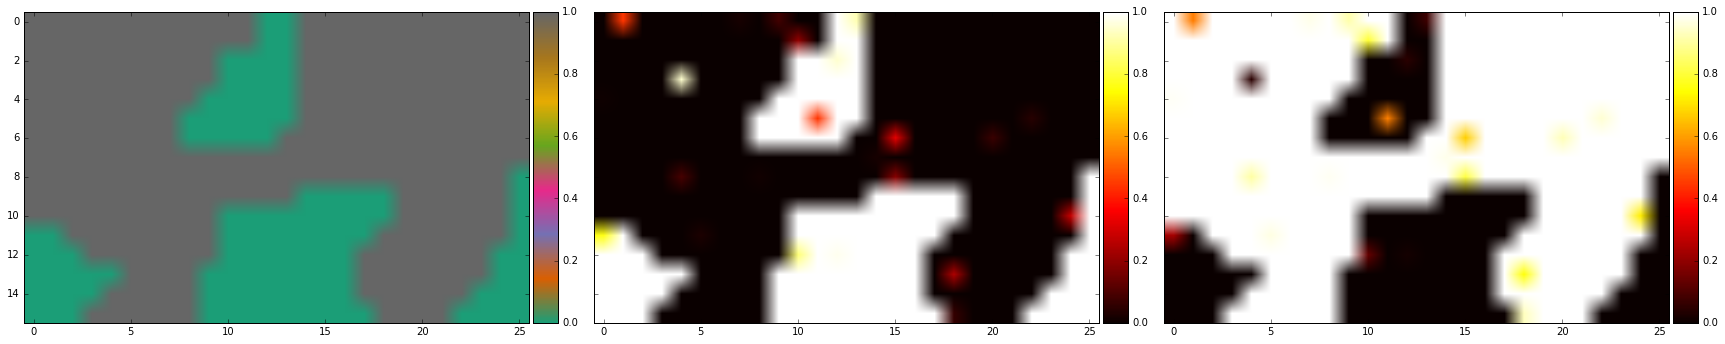

In [63]:
see_Q_Z(Q_Z.reshape((K,Z_shape[1], Z_shape[0]), order='F').transpose((0,2,1)), target_object_map=best_start_map_image)

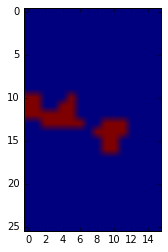

In [91]:
plt.imshow(test_windows[0].reshape(Z_shape[1], Z_shape[0], order='F'))

In [64]:
Q_Z.shape

(2, 416)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(Q_Z[0].reshape((Z_shape[1],Z_shape[0])).T)
plt.subplot(1,2,2)
plt.imshow(Q_Z[1].reshape((Z_shape[1],Z_shape[0])).T)

In [ ]:
Q_Z.shape

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.imshow(best_start_map_image, cmap='Dark2')
plt.title('best')

plt.subplot(1,2,1)
plt.imshow(test_object_map_image, cmap='Dark2')
plt.title('target')

#### Evaluate predictive distribution

#### Main loop


In [ ]:
##other scalars
t = 1




while (delta_ELBO > min_delta_ELBO) and (t <= max_t):
    
    
    ##put lkhd in log domain
    lnP_star = np.log(P_star).astype(floatX)
    
    ##coordinate ascent on variational posteriors of object map pixels
    for d in range(D):
        Z_prime_samples, Z_prime_samples_1hot = Z_sample_func(Q_Z, M,K,Z_shape[0],Z_shape[1],upscale)
        Z_prime_samples = Z_prime_samples.astype(floatX)
        Z_prime_samples_1hot = Z_prime_samples_1hot.astype(floatX)

        oc_probs = np.zeros((K, n_train, K),dtype=floatX)
        v = np.zeros((K,1), dtype=floatX)
        for k in range(K): 
            Z_prime_samples_1hot[:,:,d] = 0.    ##clear out object assignment for pixel d
            Z_prime_samples_1hot[:,k, d] = 1.   ##assign pixel d to object k
            oc_probs[k,:,:] = object_count_prob_func(Z_prime_samples_1hot, train_windows, K) ##calculate object count probs. given this assignment
            v[k] = np.dot(Z_prime_samples_1hot[0,:,d], Eln_pi,)               ##compare current assignment to prior over assignments
        Q_Z[:, d] = Q_z_update_func(oc_probs, lnP_star, v).squeeze() ##update variational posterior for pixel d
 
    
    ##update lkhd params
    Z_prime_samples, Z_prime_samples_1hot = Z_sample_func(Q_Z, M,K,Z_shape[0],Z_shape[1],upscale)
    Z_prime_samples = Z_prime_samples.astype(floatX)
    Z_prime_samples_1hot = Z_prime_samples_1hot.astype(floatX)

    oc_probs = object_count_prob_func(Z_prime_samples_1hot, train_windows, K)
    theta_star, P_star, lnQ_theta, Q_theta = lkhd_update_func(P_theta, oc_probs, lkhd_param_grid)
    
    ##update prior params
    q_Z = Q_Z.sum(axis=1, keepdims=True)
    Eln_pi, E_pi = prior_update_func(q_Z, alpha_0)
    
    ##calculate ELBO
    badness_of_fit, posterior_entropy, ELBO_history[t] = ELBO_update_func(Q_Z, lnQ_theta.max())
    
    ##update ELBO convergence criteria
    delta_ELBO = np.abs(ELBO_history[t]-ELBO_old)
    ELBO_old = ELBO_history[t]
    
    
    ##calcualte pred. dist
    prc_correct[t],_ = percent_correct(Q_Z, M, Z_shape[0],Z_shape[1],upscale,test_responses, test_windows, theta_star[0], theta_star[1])
    ln_PD[t] = eval_log_pred_dist(Q_Z, M, Z_shape[0],Z_shape[1],upscale,test_responses, test_windows, theta_star[0], theta_star[1]).mean()
    if prc_correct[t] > best_prc_correct:
        print '!new best!'
        best_prc_correct = prc_correct[t]
        best_ln_PD = ln_PD[t]
        best_Q_Z = Q_Z.copy()
        best_theta = theta_star.copy()
    
    print '============================================='
    print '===========ELBO: %f' %(ELBO_old)
    print 'badness of fit: %f' %(badness_of_fit)
    print 'posterior_entropy: %f' %(posterior_entropy)
    print '\n'
    
    print 'mean log of predictive distribution over test samples: %f' %(ln_PD[t])
    print '\n'
    
    print 'pecent correct over test samples: %f' %(prc_correct[t])
    print '\n'

    
    print 'noise parameters: %f, %f' %(theta_star[0],theta_star[1])
    t += 1
ELBO = ELBO_history[:t-1]
ln_PD = ln_PD[:t-1]
prc_correct = prc_correct[:t-1]

In [ ]:
# fig = plt.figure(figsize=(10,10))
# fig, ax = plt.subplots()
# ax.plot(ELBO)
# ax.set_xlabel('iteration', color='b')
# ax.set_ylabel('ELBO', color='b')
# ax.tick_params('y', colors='b')

fig, ax = plt.subplots()
ax.plot(prc_correct)
ax.set_xlabel('iteration', color='b')
ax.set_ylabel('precent correct', color='b')
ax.tick_params('y', colors='b')


ax2 = ax.twinx()
ax2.plot(ln_PD, 'r')
ax2.set_ylabel('pred. dist', color='r')
ax2.tick_params('y', colors='r')


In [ ]:
# see_Q_Z(Q_Z.reshape((K,image_dimensions[0], image_dimensions[1])), target_object_map=best_start_map_image)
see_Q_Z(best_Q_Z.reshape((K,image_dimensions[0], image_dimensions[1])), target_object_map = test_object_map_image)


In [ ]:
print best_theta


In [ ]:
_=see_Z_sample(Z[0], image_dimensions)

In [ ]:
see_Q_theta(Q_theta, lkhd_param_grid)

In [ ]:
from imagery_psychophysics.src.stirling_maps import stirling_num_of_2nd_kind as snk

In [ ]:
snk(16**2,4)